#### This file creates a series of visuals that demonstrate the overall pay inequality across the city of Boston. 

In [1]:
## Load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
## Load the data made in the cleaning script
localPath = "data/"
allEarnings = pd.read_csv((localPath + "earningsByYear.csv"))
    # This is the wide dataset 
longEarnings = pd.read_csv((localPath + "earningsLong.csv"))
    # This is the long dataset

##### For the first visual, I need to group the data by gender across all years, so I use the allEarnings data to create counts of men and women for each year in the data. This data returns wide however, and for the purpose of plotting these points over time, I need it long by year and gender. The melt function returns each column of "earningsX" as a record in the column 'variable' and the count of men and women in each year in the value column. In order to graph the X axis as a year, I convert the "earningsX" strings into integers. 

In [3]:
countsByGender = allEarnings.groupby('gender').count().reset_index()
countsByGender = countsByGender.melt(id_vars="gender",
                 value_vars=['earnings2011', 'earnings2012','earnings2013',
                            'earnings2014', 'earnings2015','earnings2016','earnings2017'])
countsByGender['variable'] = countsByGender['variable'].str.replace("earnings","").astype("int64")
countsByGender = countsByGender.sort_values(by='gender',ascending = False)

##### For the plots, I set the style with seaborn and using the figsize argument of subplots set the desired size of the graph. The  first seaborn point plot draws a line graph of the data over time using the mean value for each gender and year in the long data. In the second pointplot, the data is already unique to the gender/year level so it plots the actual counts from the data. I also despine the figures for clarity and save them to their respective output files. 

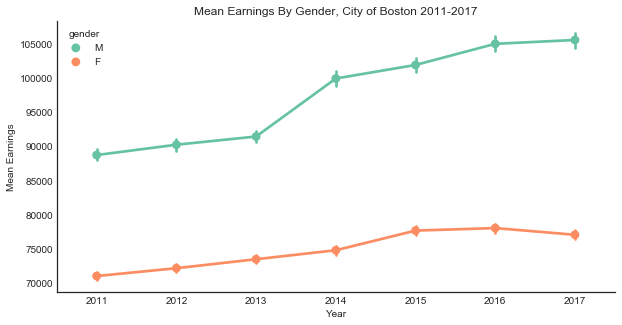

In [8]:
sns.set_style("white")
fig= plt.subplots(figsize = (10,5))
sns.pointplot(x="year", y="total", hue="gender",data=longEarnings,palette="Set2").set(
    xlabel = "Year",ylabel = "Mean Earnings")
sns.despine()
plt.title("Mean Earnings By Gender, City of Boston 2011-2017")
plt.savefig('earningsOverTime.jpeg')

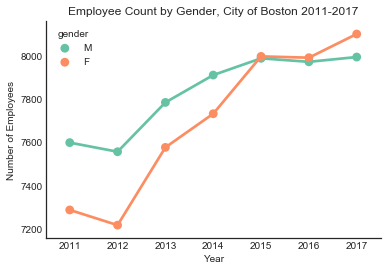

In [10]:
sns.pointplot(x="variable",y="value",hue = "gender",
              data = countsByGender,palette ="Set2").set(xlabel = "Year",
                                                      ylabel = "Number of Employees")

sns.despine()
plt.title("Employee Count by Gender, City of Boston 2011-2017")
plt.savefig('employeeCountOverTime.jpeg')

##### For the next set of visalizations, I need to get the top five largest job titles in the City, so I use count values and a sort to get the names of the first five biggest jobs.

In [11]:
top5 = allEarnings.groupby(['title']).earnings2017.count(
).reset_index().sort_values("earnings2017",ascending = False).title.tolist()[:5]

##### Then I subset the full wide dataset for employees with only those five job titles. I also make a vector of the top five titles sorted by overall median salary to provide a sort order for the plot later on.  

In [12]:
topFiveTitles = allEarnings[allEarnings['title'].isin(top5)]
topFiveMed = topFiveTitles.groupby(['title']).median().reset_index().sort_values(
    by="earnings2017").title.tolist()

##### This chunk of code creates the counts of men and women in each title for the year 2017 and determines the percent of each group.

In [16]:
counts = topFiveTitles.groupby(['title','gender']).count().reset_index()
counts = counts[['title','gender','earnings2017']]
counts = counts.pivot_table(index="title",columns="gender",values="earnings2017")
counts["totalN"] = counts.sum(axis=1)
counts["percentF"] = (counts["F"]/counts["totalN"])*100
counts["percentM"] = (counts["M"]/counts["totalN"])*100
counts = counts.sort_values(by="totalN",ascending=False)
counts

gender,F,M,totalN,percentF,percentM
title,,,,,
Teacher,3434,1202,4636,74.072476,25.927524
Police Officer,177,980,1157,15.298185,84.701815
Fire Fighter,19,757,776,2.448454,97.551546
Paraprofessional,602,172,774,77.777778,22.222222
Police Detective,45,241,286,15.734266,84.265734


##### Then I use the seaborn boxplot function to plot the distribution of earnings for each title, with a distinction between men and women. I chose to hide outliers with the showfliers option, and sort the box plots according to the sort order in topFiveMed. Finally, I move the location of the legend and increase the font size for readability.

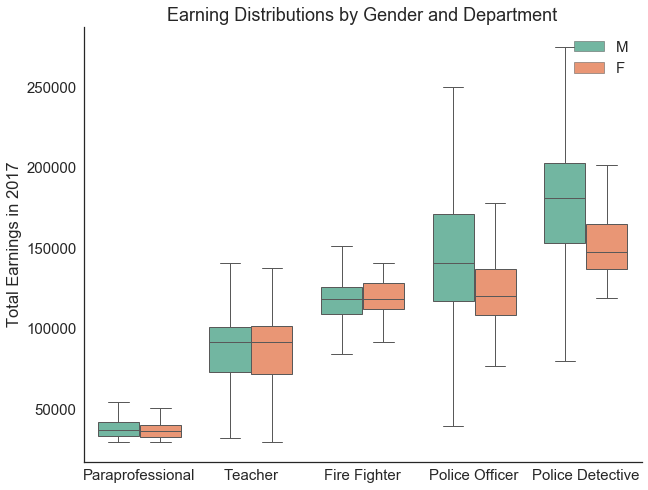

In [15]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(
    x = 'title',y = "earnings2017", hue = 'gender', dodge = True,
    data=topFiveTitles, palette="Set2", order = topFiveMed,
    linewidth = 1, width = .75, showfliers=False).set(
    ylabel = "Total Earnings in 2017", xlabel = "")
ax.legend(loc=1)
sns.set(font_scale=1.5)
sns.despine()
plt.title("Earning Distributions by Gender and Department")
plt.savefig('earningsByTitleAndSex.jpeg')

##### The last bit of code depends on the output of the Regress.R file where I model the effect of being male across all departments. After reading in the coefficent data, I create a bar plot of the estimated effects, sorted by lowest to larges. I also create custom labels for each bar using the plt.text method and custom labels created from the actual coefficent data. The tight layout function ensures that the edges of the graph are not cut off when saving. 

In [17]:
model = pd.read_csv((localPath + "modelCoefficents.csv"))
model = model.sort_values(by="male")

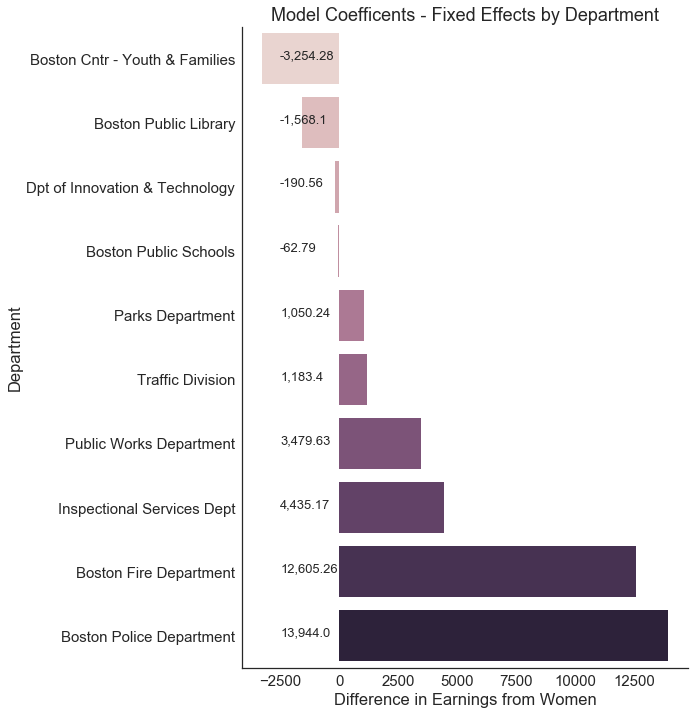

In [19]:
sns.set_style("white")
fig= plt.subplots(figsize = (10,10))
sns.barplot(y="department", x="male",data=model,palette=sns.cubehelix_palette(10)).set(
    xlabel = "Difference in Earnings from Women",ylabel = "Department")
ytickPos = range(len(model['department']))
    # This is a vector to tell the graph where on the y axis to place the label.
label = ["{:,}".format(round(x,2)) for x in model['male']]
    # The format method ensure that the data has a comma in the appropriate spot. 
for i in range(len(label)):
     plt.text(x = -2500, y = ytickPos[i], s = label[i], size = 13)
# Iterating over every label in the vector, place the ith label in the designated spot.
sns.set(font_scale=1.5)
plt.tight_layout()
sns.despine()
plt.title("Model Coefficents - Fixed Effects by Department")
plt.savefig('fixedEffectsCoefficents.jpeg')